## Import libraries

In [168]:
import os
import pandas as pd
import glob
import pickle
import time
import seaborn as sns

from dask.diagnostics import ProgressBar

from arboreto.algo import grnboost2, genie3
from arboreto.utils import load_tf_names

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize

## Change working directory to pySCENIC src directory

In [21]:
resources_folder = os.getcwd().split('src')[0] + 'data'
results_folder = os.getcwd().split('src')[0] + 'results'
expression_path = resources_folder+'/ExpressionMMRF.csv'
tf_path = resources_folder+'/hs_hgnc_curated_tfs.txt'

## Read expression matrix; Genes should be columns

In [108]:
ex_matrix = pd.read_csv(expression_path,index_col = 0)

## Load TF names

In [86]:
tf_names = load_tf_names(tf_path)

## Subset expression matrix to facilitate runtime

In [109]:
#ex_matrix_tfs = ex_matrix.loc[set(ex_matrix.index)&set(tf_names[0:400]),:]
#ex_matrix_tfs.shape
#probe_list = list(set(ex_matrix.index[0:2000])|set(ex_matrix_tfs.index))
#ex_matrix = ex_matrix.loc[probe_list,:]
ex_matrix = ex_matrix.T

In [110]:
ex_matrix.shape

(881, 16216)

In [ ]:
# record times
# Num genes   minutes   Num TFs
# 182         0.298     100
# 481         0.805     100
# 880         1.788     100
# 955         2.651     200
# 2282        10.769    400       

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

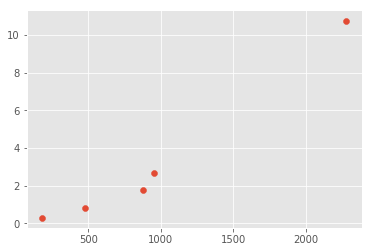

In [90]:
plt.scatter([182,481,880,955,2282],[0.298,0.805,1.788,2.651,10.769])

## Apply GRNBoost2 to generate adjacency matrix

In [111]:
t1 = time.time()
adjacency = grnboost2(expression_data=ex_matrix,
                    tf_names=tf_names)
t2 = time.time()

print((t2-t1)/60.0)
adjacency.head()

/anaconda3/lib/python3.7/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


250.39267294804256


,TF,target,importance
1088,ZFY,UTY,563.034661
1088,ZFY,TMSB4Y,434.150452
1088,ZFY,EIF1AY,433.848874
726,BORCS8-MEF2B,MEF2B,338.971156
1088,ZFY,USP9Y,301.024181


## Write adjacency matrix to file

In [112]:
adjacency.to_csv(os.path.join(results_folder,'adjacency_mmrf.tsv'), sep='\t', header=False, index=False)

## Infer modules from adjacencies matrix

In [113]:
modules = list(modules_from_adjacencies(adjacency, ex_matrix))


2020-11-06 03:41:04,260 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-11-06 03:41:07,208 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.02s.  

In [114]:
len(modules)

6430

## Load TF motif database

In [123]:
# Filenames for saving
REGULONS_FNAME = os.path.join(results_folder, "regulons.p")
MOTIFS_FNAME = os.path.join(results_folder, "motifs.csv")

# Load motif database
MOTIF_ANNOTATIONS_FNAME = os.path.join(resources_folder, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
#DATABASES_GLOB = os.path.join(resources_folder, "hg19-tss-centered-10kb-10species.mc9nr.feather")
DATABASES_GLOB = os.path.join(resources_folder, "hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather")
DATABASES_GLOB

# Rank databases (if there are more than one)
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")]

## Mechanistic inference of regulons

In [124]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

[##############                          ] | 35% Completed | 12min  6.7s


2020-11-06 16:59:57,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 14min 13.5s


2020-11-06 17:02:04,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 17min 42.5s


2020-11-06 17:05:33,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed | 23min 29.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [125]:
# Inspect df
df.head()

Enrichment  \
                                AUC   
TF     MotifID                        
ARID3A tfdimers__MD00467   0.047842   
       tfdimers__MD00454   0.046079   
ARID5B cisbp__M0107        0.059708   
ARX    cisbp__M0984        0.066160   
       cisbp__M1102        0.067342   

                                                                             \
                                                                 Annotation   
TF     MotifID                                                                
ARID3A tfdimers__MD00467                         gene is directly annotated   
       tfdimers__MD00454                         gene is directly annotated   
ARID5B cisbp__M0107       gene is orthologous to ENSMUSG00000019947 in M...   
ARX    cisbp__M0984       motif similar to flyfactorsurvey__Al_SOLEXA_FB...   
       cisbp__M1102       gene is orthologous to ENSMUSG00000035277 in M...   

                                                                             \
                                                                    Context   
TF     MotifID                                                                
ARID3A tfdimers__MD00467  (activating, weight>75.0%, hg38__refseq-r80__1...   
       tfdimers__MD00454  (activating, weight>75.0%, hg38__refseq-r80__1...   
ARID5B cisbp__M0107       (activating, weight>75.0%, hg38__refseq-r80__1...   
ARX    cisbp__M0984       (activating, weight>75.0%, hg38__refseq-r80__1...   
       cisbp__M1102       (activating, weight>75.0%, hg38__refseq-r80__1...   

                                                                              \
                         MotifSimilarityQvalue       NES OrthologousIdentity   
TF     MotifID                                                                 
ARID3A tfdimers__MD00467              0.000000  3.391897            1.000000   
       tfdimers__MD00454              0.000000  3.066350            1.000000   
ARID5B cisbp__M0107                   0.000000  3.205356            0.880471   
ARX    cisbp__M0984                   0.000588  3.011900            0.281863   
       cisbp__M1102                   0.000640  3.127924            0.960854   

                                    \
                         RankAtMax   
TF     MotifID                       
ARID3A tfdimers__MD00467      1366   
       tfdimers__MD00454      1265   
ARID5B cisbp__M0107            816   
ARX    cisbp__M0984            646   
       cisbp__M1102            825   

                                                                             
                                                                TargetGenes  
TF     MotifID                                                               
ARID3A tfdimers__MD00467  [(KDM4B, 0.33388587204604914), (DAG1, 0.579111...  
       tfdimers__MD00454  [(UQCRHL, 0.33388587204604914), (DAG1, 0.57911...  
ARID5B cisbp__M0107       [(NR4A3, 10.508982263946525), (SRF, 1.56750396...  
ARX    cisbp__M0984       [(RARA, 0.4214097097239921), (HMX2, 14.2779705...  
       cisbp__M1102       [(RARA, 0.4214097097239921), (GATA3, 14.277970...

In [127]:
# Inspect regulons
regulons[1]

Regulon(name='ALX4(+)', gene2weight=<frozendict {'LMO1': 7.744837917185918, 'NRXN3': 7.744837917185918, 'AP5B1': 8.056782055087176, 'TNFRSF19': 8.056782055087176, 'DNAH2': 1.7070632657405205, 'C1QTNF4': 8.056782055087176, 'FGFR2': 8.056782055087176, 'PLEKHS1': 2.394234499849559, 'HOXB6': 8.056782055087176, 'DLEU1': 1.5063947563546851, 'LAMB1': 1.5063947563546851, 'EPHA8': 2.8094174447216425, 'GABBR2': 8.056782055087176, 'UNC5D': 2.394234499849559, 'LRRC3B': 7.744837917185918, 'NEUROD2': 7.744837917185918, 'SLC24A2': 8.056782055087176, 'AHCYL2': 2.526063420017535, 'VSTM2L': 0.32696451933885395, 'HAS2': 1.7070632657405205, 'IPO7': 1.0, 'CDON': 0.720611720822531, 'CALN1': 0.9158930451397981}>, gene2occurrence=<frozendict {}>, transcription_factor='ALX4', context=frozenset({'activating', 'taipale_cyt_meth__ARGFX_YTAATCTAATTAG_eDBD.png'}), score=3.7224076173332445, nes=0.0, orthologous_identity=0.0, similarity_qvalue=0.0, annotation='')

## Run AUCell

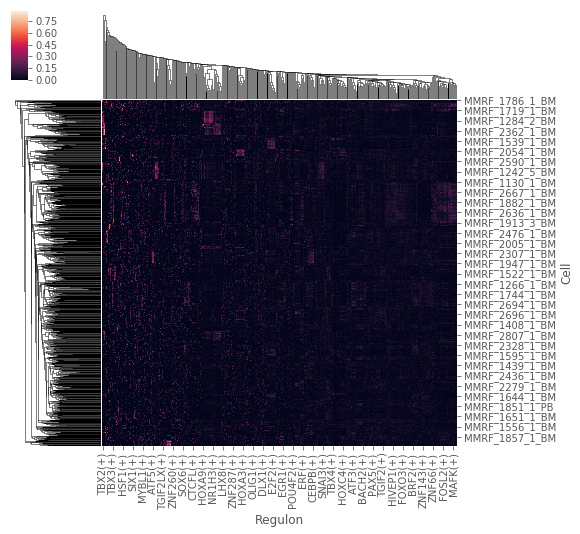

In [129]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
sns.clustermap(auc_mtx, figsize=(8,8))

In [130]:
auc_mtx.head()

Regulon,AHRR(+),ALX4(+),AR(+),ARID3A(+),ARID5B(+),ARNT(+),ARX(+),ASCL1(+),ASCL2(+),ATF1(+),...,ZNF76(+),ZNF768(+),ZNF787(+),ZNF836(+),ZNF84(+),ZNF845(+),ZNF91(+),ZSCAN23(+),ZSCAN26(+),ZXDC(+)
Cell,,,,,,,,,,,,,,,,,,,,,
MMRF_1270_1_BM,0.061541,0.000000,0.000000,0.016297,0.007889,0.037597,0.000641,0.023150,0.0,0.023139,...,0.044477,0.018676,0.000000,0.0,0.0,0.000000,0.139481,0.000000,0.224313,0.014065
MMRF_1037_1_BM,0.000000,0.000000,0.036325,0.060500,0.043757,0.028316,0.024741,0.010352,0.0,0.063608,...,0.016713,0.017130,0.199131,0.0,0.0,0.000000,0.000756,0.043946,0.000000,0.002734
MMRF_2644_1_BM,0.000000,0.000000,0.000000,0.004376,0.065091,0.017555,0.047469,0.014124,0.0,0.052968,...,0.016489,0.005089,0.001642,0.0,0.0,0.552996,0.000000,0.000000,0.000000,0.043784
MMRF_1235_1_BM,0.000000,0.000000,0.000000,0.052027,0.004724,0.151987,0.014938,0.012695,0.0,0.048011,...,0.017517,0.008807,0.003114,0.0,0.0,0.000000,0.028997,0.016089,0.345351,0.000000
MMRF_1621_1_BM,0.000000,0.006598,0.022857,0.009536,0.004889,0.000769,0.009560,0.006619,0.0,0.029594,...,0.081607,0.002469,0.007554,0.0,0.0,0.000000,0.000000,0.035882,0.000000,0.140855


In [131]:
auc_mtx.to_csv(os.path.join(results_folder,"auc_matrix.csv"))

## Binarize regulon activity

In [136]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=5 )
binary_mtx.head()

Regulon,AHRR(+),ALX4(+),AR(+),ARID3A(+),ARID5B(+),ARNT(+),ARX(+),ASCL1(+),ASCL2(+),ATF1(+),...,ZNF76(+),ZNF768(+),ZNF787(+),ZNF836(+),ZNF84(+),ZNF845(+),ZNF91(+),ZSCAN23(+),ZSCAN26(+),ZXDC(+)
Cell,,,,,,,,,,,,,,,,,,,,,
MMRF_1270_1_BM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
MMRF_1037_1_BM,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
MMRF_2644_1_BM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
MMRF_1235_1_BM,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
MMRF_1621_1_BM,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [137]:
binary_mtx.to_csv(os.path.join(results_folder,"binary_regulon_matrix.csv"))

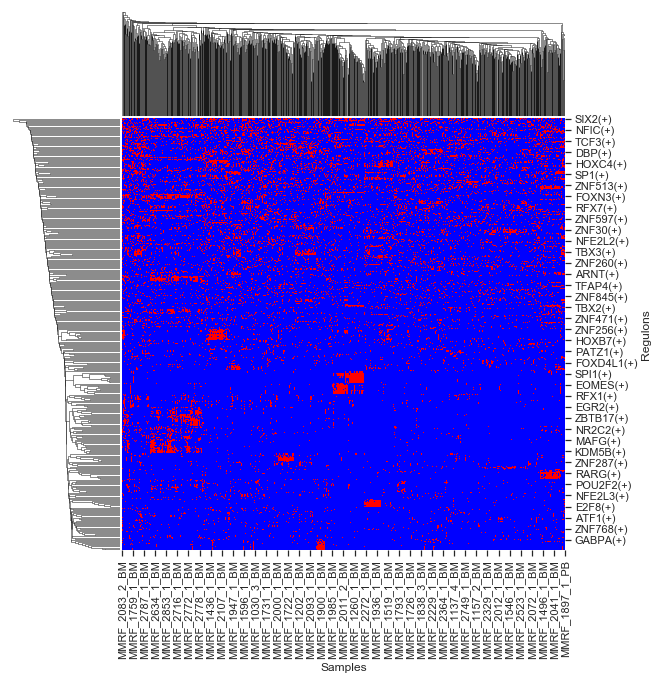

In [166]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(binary_mtx.T, 
               cmap="bwr", figsize=(10,10))

#g.ax_heatmap.set_xticklabels([])
#g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Samples')
g.ax_heatmap.set_ylabel('Regulons')

g.cax.set_visible(False)
g.fig.savefig(os.path.join(results_folder, 'scenic_regulon_biclusters.png'), format='png')

## Load MINER regulon matrices

In [147]:
#Set path to MINER results
miner_folder = os.path.join(os.path.expanduser("~"),"Desktop",
                            "GitHub","miner","miner","results_minCorrelation_0o2_50_allFiles")

In [156]:
#Define MINER regulon file paths
overExpressedMembersMatrix_file = os.path.join(miner_folder,"overExpressedMembers.csv")
underExpressedMembersMatrix_file = os.path.join(miner_folder,"underExpressedMembers.csv")
regulonDf_file = os.path.join(miner_folder,"regulonDf.csv")

In [157]:
#Read MINER regulon files
overExpressedMembersMatrix = pd.read_csv(overExpressedMembersMatrix_file,index_col=0,header=0)
underExpressedMembersMatrix = pd.read_csv(underExpressedMembersMatrix_file,index_col=0,header=0)
regulonDf = pd.read_csv(regulonDf_file,index_col=0,header=0)

In [161]:
#Create difference matrix
diff_mmrf = overExpressedMembersMatrix - underExpressedMembersMatrix
diff_mmrf.head()

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
0,0.0,0.0,-1.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,-1.0,1.0,0.0,0.0,1.0,0.0,-1.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,-1.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Use clustermap to cluster MINER regulons

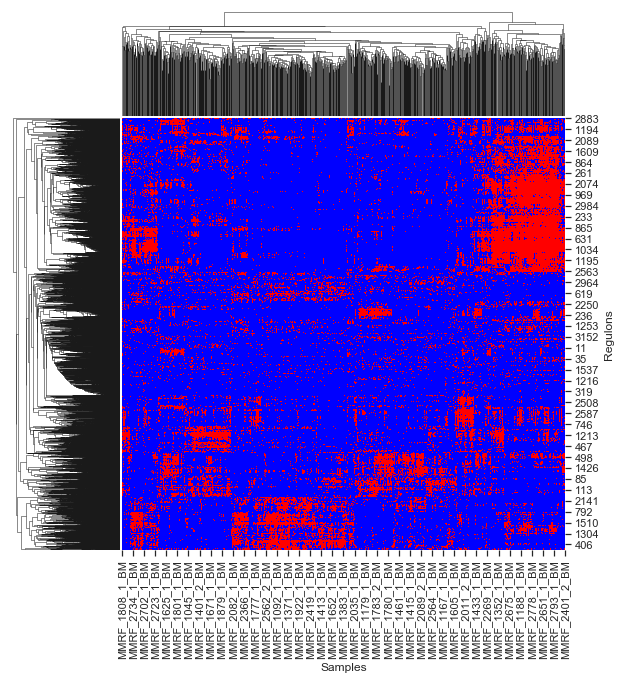

In [165]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(overExpressedMembersMatrix, 
               cmap="bwr", figsize=(10,10))

#g.ax_heatmap.set_xticklabels([])
#g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Samples')
g.ax_heatmap.set_ylabel('Regulons')

g.cax.set_visible(False)
g.fig.savefig(os.path.join(results_folder, 'miner_regulon_overexpressed_biclusters.png'), format='png')

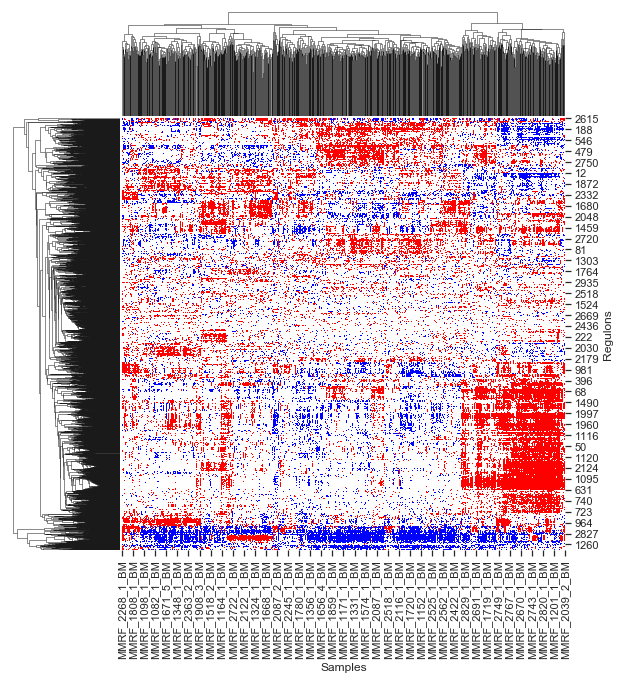

In [167]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(diff_mmrf, 
               cmap="bwr", figsize=(10,10))

#g.ax_heatmap.set_xticklabels([])
#g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Samples')
g.ax_heatmap.set_ylabel('Regulons')

g.cax.set_visible(False)
g.fig.savefig(os.path.join(results_folder, 'miner_regulon_biclusters.png'), format='png')